# Data Preprocessing: Cleaning, ETL & Feature Engineering

## Learning Objectives

By the end of this lesson, you will be able to:

1. **Understand the ETL Process**: Extract data from various sources, transform it into a usable format, and load it for analysis
2. **Handle Missing Data**: Apply appropriate imputation techniques (mean, median, mode, forward/backward fill, interpolation)
3. **Clean Data**: Identify and handle outliers, duplicates, and inconsistent data formats
4. **Engineer Features**: Create new meaningful features from existing data
5. **Select Features**: Use correlation analysis, statistical tests, and domain knowledge to select the most relevant features
6. **Build Robust Pipelines**: Create reproducible data preprocessing workflows

## Table of Contents

1. [Introduction to ETL](#introduction-to-etl)
2. [Data Extraction](#data-extraction)
3. [Data Cleaning](#data-cleaning)
4. [Missing Value Imputation](#missing-value-imputation)
5. [Feature Engineering](#feature-engineering)
6. [Feature Selection](#feature-selection)
7. [Hands-on Exercise](#hands-on-exercise)
8. [Best Practices](#best-practices)

---

## Introduction to ETL

**ETL (Extract, Transform, Load)** is a fundamental process in data science that involves:

- **Extract**: Getting data from various sources (databases, APIs, files, etc.)
- **Transform**: Cleaning, validating, and restructuring the data
- **Load**: Storing the processed data in a format suitable for analysis

The quality of your data preprocessing directly impacts the performance of your machine learning models. As the saying goes: **"Garbage in, garbage out"** - poor data quality leads to poor model performance.


## Data Extraction

Let's start by importing the necessary libraries and exploring different ways to extract data:


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
# Load the data
df = pd.read_csv('sample_demographic_data.csv')

# Print the shape of the data
print(df.shape)

# Print the first 5 rows
df.head()


(1020, 13)


,customer_id,age,income,education_years,credit_score,loan_amount,employment_length,debt_to_income,previous_defaults,marital_status,employment_type,loan_purpose,target
0,1,40,44341.562353,11,459.0,33181.165308,0.924781,0.156314,0,Widowed,Self-employed,Business,0
1,2,33,34972.483357,13,563.0,4463.589043,3.087164,0.432487,0,Married,Self-employed,Personal,1
2,3,42,22693.077136,11,608.0,179608.313000,1.834260,0.529015,0,Widowed,Full-time,Car,0
3,4,53,15939.117886,13,838.0,36491.640351,0.178961,0.295708,0,Widowed,Part-time,Education,0
4,5,32,31229.288168,8,705.0,47620.026210,1.951493,0.135739,1,Divorced,Full-time,Home,1


### Data Exploration and Quality Assessment

Before we start cleaning, let's explore our data and identify the quality issues:


In [4]:
# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\n=== DUPLICATE RECORDS ===")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

print("\n=== BASIC STATISTICS ===")
df.describe()


=== DATASET OVERVIEW ===
Shape: (1020, 13)
Memory usage: 0.27 MB

=== DATA TYPES ===
customer_id            int64
age                    int64
income               float64
education_years        int64
credit_score         float64
loan_amount          float64
employment_length    float64
debt_to_income       float64
previous_defaults      int64
marital_status        object
employment_type       object
loan_purpose          object
target                 int64
dtype: object

=== MISSING VALUES ===
              Missing Count  Missing Percentage
income                  101            9.901961
credit_score             64            6.274510

=== DUPLICATE RECORDS ===
Number of duplicate rows: 19

=== BASIC STATISTICS ===


,customer_id,age,income,education_years,credit_score,loan_amount,employment_length,debt_to_income,previous_defaults,target
count,1020.000000,1020.000000,919.000000,1020.000000,956.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000
mean,499.760784,34.125490,30521.077316,13.523529,745.861925,50925.798509,4.882837,0.289961,0.490196,0.271569
std,289.612590,12.652677,38745.060398,2.958402,957.382996,51602.273029,4.912129,0.158665,0.712225,0.444987
min,1.000000,-5.000000,5063.461821,4.000000,357.000000,310.151083,0.001205,0.006476,0.000000,0.000000
25%,247.750000,26.000000,16493.836434,12.000000,576.000000,14196.375688,1.376105,0.168013,0.000000,0.000000
50%,499.500000,35.000000,23218.107597,13.000000,654.000000,33881.846629,3.299203,0.268824,0.000000,0.000000
75%,751.250000,42.000000,33078.444664,15.000000,719.000000,70631.910261,7.059530,0.393941,1.000000,1.000000
max,1000.000000,81.000000,535116.917454,25.000000,9999.000000,366950.028344,37.626017,0.819733,5.000000,1.000000


## Data Cleaning

Data cleaning is the process of detecting and correcting (or removing) corrupt, inaccurate, or irrelevant records from a dataset. Let's systematically address the data quality issues we identified.


### Step 1: Handle Duplicates

First, let's remove duplicate records:


In [5]:
# Remove duplicates
print(f"Before removing duplicates: {len(df)} rows")
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {len(df_clean)} rows")
print(f"Removed {len(df) - len(df_clean)} duplicate rows")


Before removing duplicates: 1020 rows
After removing duplicates: 1001 rows
Removed 19 duplicate rows


### Step 2: Handle Invalid Values

Let's identify and fix invalid values (negative ages, impossible credit scores):


In [6]:
# Check for invalid values
print("=== INVALID VALUES DETECTION ===")

# Negative ages
negative_ages = df_clean[df_clean['age'] < 0]
print(f"Negative ages: {len(negative_ages)}")

# Invalid credit scores (should be 300-850)
invalid_credit = df_clean[(df_clean['credit_score'] < 300) | (df_clean['credit_score'] > 850)]
print(f"Invalid credit scores: {len(invalid_credit)}")

# Show examples
print("\nExamples of invalid data:")
print("Negative ages:")
print(negative_ages[['customer_id', 'age']].head())

print("\nInvalid credit scores:")
print(invalid_credit[['customer_id', 'credit_score']].head())

# Fix invalid values
print("\n=== FIXING INVALID VALUES ===")

# Replace negative ages with median age
median_age = df_clean[df_clean['age'] > 0]['age'].median()
df_clean.loc[df_clean['age'] < 0, 'age'] = median_age
print(f"Fixed {len(negative_ages)} negative ages with median age: {median_age}")

# Replace invalid credit scores with median credit score
median_credit = df_clean[(df_clean['credit_score'] >= 300) & (df_clean['credit_score'] <= 850)]['credit_score'].median()
df_clean.loc[(df_clean['credit_score'] < 300) | (df_clean['credit_score'] > 850), 'credit_score'] = median_credit
print(f"Fixed {len(invalid_credit)} invalid credit scores with median: {median_credit}")


=== INVALID VALUES DETECTION ===
Negative ages: 16
Invalid credit scores: 31

Examples of invalid data:
Negative ages:
     customer_id  age
33            34   -5
99           100   -5
124          125   -5
173          174   -5
183          184   -5

Invalid credit scores:
     customer_id  credit_score
35            36        9999.0
38            39        9999.0
71            72        9999.0
157          158        9999.0
192          193         878.0

=== FIXING INVALID VALUES ===
Fixed 16 negative ages with median age: 35.0
Fixed 31 invalid credit scores with median: 647.5


### Step 3: Standardize Categorical Data

Let's fix inconsistent categorical values (case sensitivity):


In [7]:
# Check unique values in categorical columns
print("=== CATEGORICAL DATA STANDARDIZATION ===")
print("Marital status unique values:")
print(df_clean['marital_status'].value_counts())

# Standardize marital status
df_clean['marital_status'] = df_clean['marital_status'].str.title()
print("\nAfter standardization:")
print(df_clean['marital_status'].value_counts())

# Check employment type
print("\nEmployment type unique values:")
print(df_clean['employment_type'].value_counts())


=== CATEGORICAL DATA STANDARDIZATION ===
Marital status unique values:
marital_status
Married     257
Widowed     233
Single      227
Divorced    206
single       48
MARRIED      30
Name: count, dtype: int64

After standardization:
marital_status
Married     287
Single      275
Widowed     233
Divorced    206
Name: count, dtype: int64

Employment type unique values:
employment_type
Part-time        268
Self-employed    255
Full-time        253
Unemployed       225
Name: count, dtype: int64


## Missing Value Imputation

Missing data is one of the most common data quality issues. The choice of imputation method depends on:
- **Missing Data Mechanism**: MCAR (Missing Completely At Random), MAR (Missing At Random), or MNAR (Missing Not At Random)
- **Data Type**: Numerical vs. Categorical
- **Missing Percentage**: How much data is missing
- **Business Context**: Domain knowledge about the data

Let's explore different imputation strategies:


=== MISSING VALUES BEFORE IMPUTATION ===
income          100
credit_score     64
dtype: int64


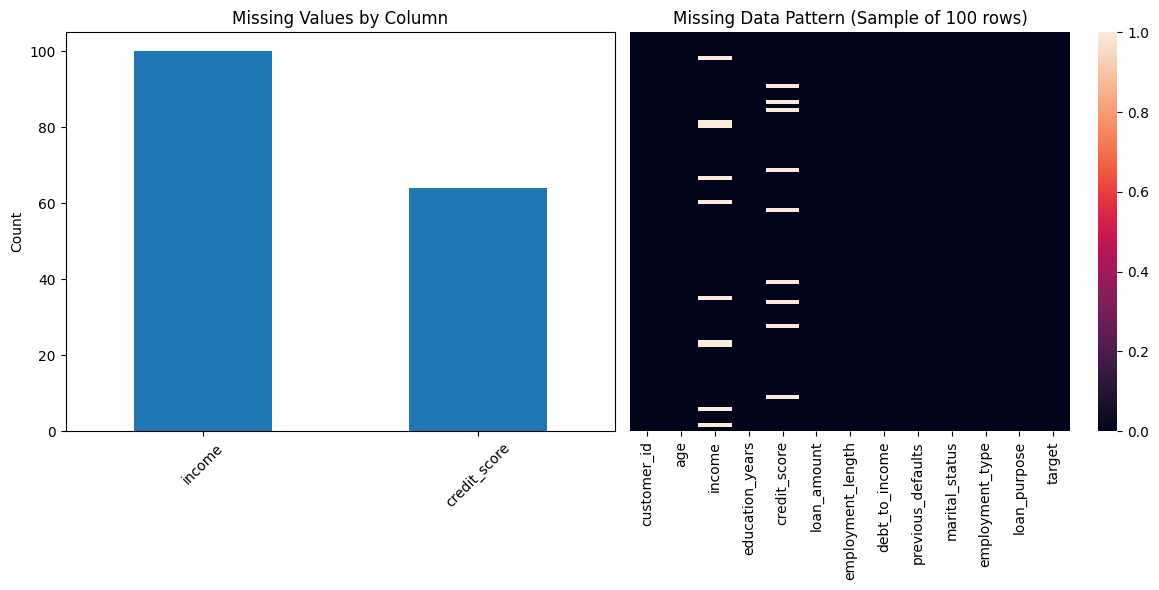

In [8]:
# Create a copy for imputation experiments
df_impute = df_clean.copy()

# Check missing values before imputation
print("=== MISSING VALUES BEFORE IMPUTATION ===")
missing_before = df_impute.isnull().sum()
print(missing_before[missing_before > 0])

# Visualize missing data pattern
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
missing_before[missing_before > 0].plot(kind='bar')
plt.title('Missing Values by Column')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
# Create a heatmap of missing values for a sample
sample_data = df_impute.sample(100, random_state=42)
sns.heatmap(sample_data.isnull(), cbar=True, yticklabels=False)
plt.title('Missing Data Pattern (Sample of 100 rows)')

plt.tight_layout()
plt.show()


### Imputation Method 1: Simple Statistical Imputation

For numerical data, we can use mean, median, or mode:


Mean imputation for income: 30680.28
Median imputation for credit_score: 647.50


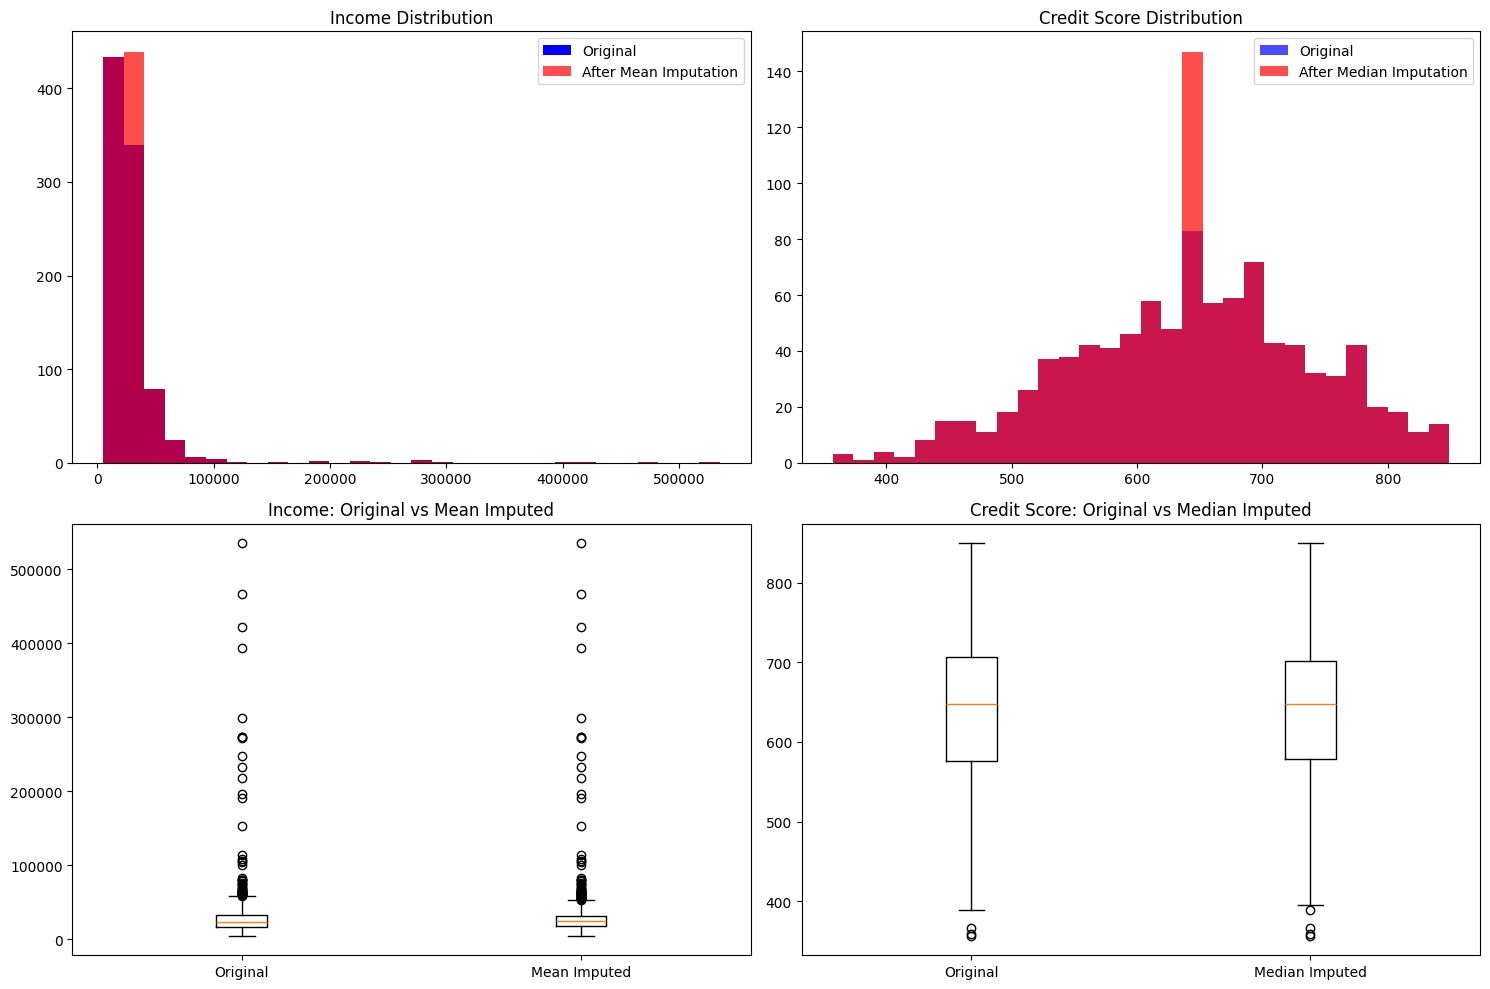

In [9]:
# Method 1: Mean imputation for income
df_mean = df_impute.copy()
mean_income = df_mean['income'].mean()
df_mean['income'].fillna(mean_income, inplace=True)

print(f"Mean imputation for income: {mean_income:.2f}")

# Method 2: Median imputation for credit_score
df_median = df_impute.copy()
median_credit = df_median['credit_score'].median()
df_median['credit_score'].fillna(median_credit, inplace=True)

print(f"Median imputation for credit_score: {median_credit:.2f}")

# Compare distributions before and after imputation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Income distribution
axes[0, 0].hist(df_impute['income'].dropna(), bins=30, label='Original', color='blue')
axes[0, 0].hist(df_mean['income'], bins=30, alpha=0.7, label='After Mean Imputation', color='red')
axes[0, 0].set_title('Income Distribution')
axes[0, 0].legend()

# Credit score distribution
axes[0, 1].hist(df_impute['credit_score'].dropna(), bins=30, alpha=0.7, label='Original', color='blue')
axes[0, 1].hist(df_median['credit_score'], bins=30, alpha=0.7, label='After Median Imputation', color='red')
axes[0, 1].set_title('Credit Score Distribution')
axes[0, 1].legend()

# Box plots to show impact
axes[1, 0].boxplot([df_impute['income'].dropna(), df_mean['income']], labels=['Original', 'Mean Imputed'])
axes[1, 0].set_title('Income: Original vs Mean Imputed')

axes[1, 1].boxplot([df_impute['credit_score'].dropna(), df_median['credit_score']], labels=['Original', 'Median Imputed'])
axes[1, 1].set_title('Credit Score: Original vs Median Imputed')

plt.tight_layout()
plt.show()


### Imputation Method 2: Group-based Imputation

When missing data is not random (MAR), we can use group-specific statistics:


=== MISSING CREDIT SCORES BY EMPLOYMENT TYPE ===
employment_type
Full-time         0
Part-time         0
Self-employed     0
Unemployed       64
Name: credit_score, dtype: int64

Credit score imputation by employment type:
Self-employed: 647.50
Full-time: 646.00
Part-time: 650.00
Unemployed: 647.50


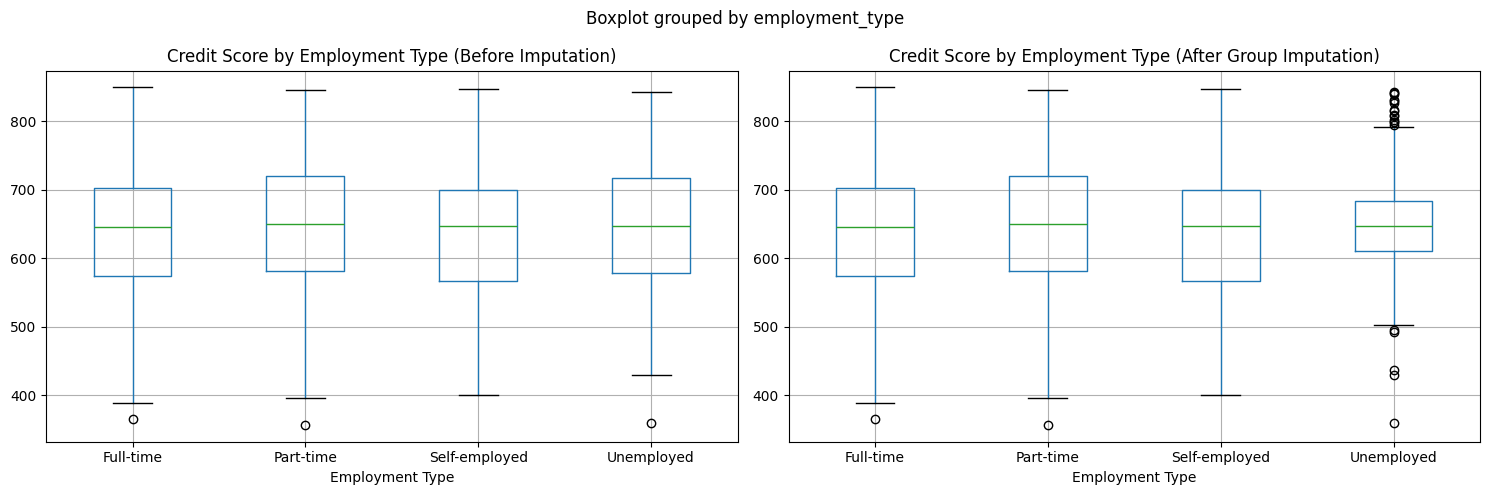

In [10]:
# Group-based imputation for credit_score by employment_type
df_group = df_impute.copy()

# Check missing credit_score by employment type
print("=== MISSING CREDIT SCORES BY EMPLOYMENT TYPE ===")
missing_by_employment = df_group.groupby('employment_type')['credit_score'].apply(lambda x: x.isnull().sum())
print(missing_by_employment)

# Impute credit_score using median by employment type
df_group['credit_score'] = df_group.groupby('employment_type')['credit_score'].transform(
    lambda x: x.fillna(x.median())
)

print(f"\nCredit score imputation by employment type:")
for emp_type in df_group['employment_type'].unique():
    median_score = df_group[df_group['employment_type'] == emp_type]['credit_score'].median()
    print(f"{emp_type}: {median_score:.2f}")

# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before imputation
df_impute.boxplot(column='credit_score', by='employment_type', ax=axes[0])
axes[0].set_title('Credit Score by Employment Type (Before Imputation)')
axes[0].set_xlabel('Employment Type')

# After imputation
df_group.boxplot(column='credit_score', by='employment_type', ax=axes[1])
axes[1].set_title('Credit Score by Employment Type (After Group Imputation)')
axes[1].set_xlabel('Employment Type')

plt.tight_layout()
plt.show()


### Imputation Method 3: Advanced Techniques

For more sophisticated imputation, we can use machine learning models:

Imputation with KNN is very powerful and can be used for both numerical and categorical data.
Random Forest imputation is also very powerful and can be used for both numerical and categorical data.


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

# Method 3a: K-Nearest Neighbors imputation
df_knn = df_impute.copy()

# Select numerical columns for KNN imputation
numerical_cols = ['age', 'income', 'education_years', 'credit_score', 'loan_amount', 
                  'employment_length', 'debt_to_income', 'previous_defaults']

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn[numerical_cols] = knn_imputer.fit_transform(df_knn[numerical_cols])

print("=== KNN IMPUTATION COMPLETED ===")
print(f"Missing values after KNN imputation: {df_knn[numerical_cols].isnull().sum().sum()}")


# Method 3b: Random Forest imputation for income
df_rf = df_impute.copy()

# Prepare features for RF imputation (exclude target and income)
rf_features = ['age', 'education_years', 'credit_score', 'loan_amount', 
               'employment_length', 'debt_to_income', 'previous_defaults']

# Create dummy variables for categorical features
df_rf_encoded = df_rf.copy()
df_rf_encoded = pd.get_dummies(df_rf_encoded, columns=['marital_status', 'employment_type', 'loan_purpose'])

# Find features that don't have missing values for income imputation
income_features = [col for col in df_rf_encoded.columns if col not in ['customer_id', 'income', 'target'] and not df_rf_encoded[col].isnull().any()]

print("Income features: ", income_features)

# Split data for RF imputation
income_missing = df_rf_encoded['income'].isnull()
income_known = df_rf_encoded[~income_missing]
income_unknown = df_rf_encoded[income_missing]

if len(income_known) > 0 and len(income_unknown) > 0:
    # Train RF model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(income_known[income_features], income_known['income'])
    
    # Predict missing income values
    predicted_income = rf_model.predict(income_unknown[income_features])
    df_rf.loc[income_missing, 'income'] = predicted_income
    
    print(f"Random Forest imputation completed for {len(predicted_income)} missing income values")
    print(f"Mean predicted income: {predicted_income.mean():.2f}")
    print(f"Std predicted income: {predicted_income.std():.2f}")




=== KNN IMPUTATION COMPLETED ===
Missing values after KNN imputation: 0
Income features:  ['age', 'education_years', 'loan_amount', 'employment_length', 'debt_to_income', 'previous_defaults', 'marital_status_Divorced', 'marital_status_Married', 'marital_status_Single', 'marital_status_Widowed', 'employment_type_Full-time', 'employment_type_Part-time', 'employment_type_Self-employed', 'employment_type_Unemployed', 'loan_purpose_Business', 'loan_purpose_Car', 'loan_purpose_Education', 'loan_purpose_Home', 'loan_purpose_Personal']
Random Forest imputation completed for 100 missing income values
Mean predicted income: 30297.79
Std predicted income: 7324.15


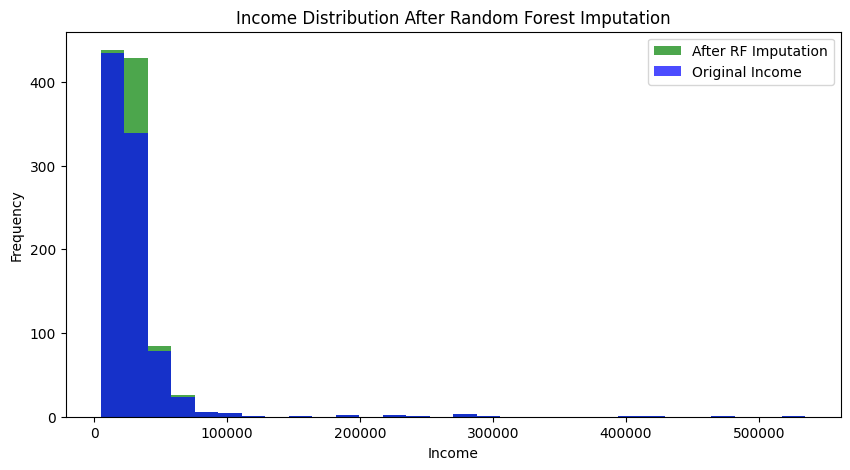

In [31]:
# plot the imputed income distribution with unimputed data also
plt.figure(figsize=(10, 5))
plt.hist(df_rf['income'], bins=30, alpha=0.7, label='After RF Imputation', color='green')
plt.title('Income Distribution After Random Forest Imputation')
plt.hist(df_impute['income'].dropna(), bins=30, alpha=0.7, label='Original Income', color='blue')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.legend()
plt.show()

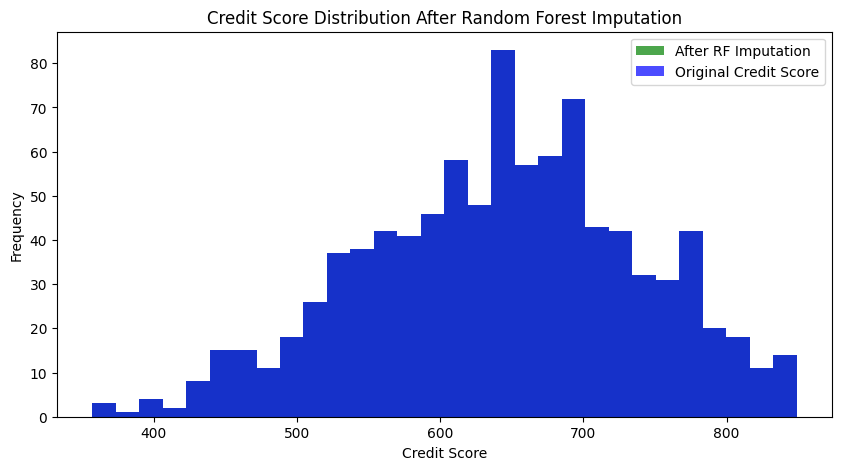

In [32]:
# Plot the imputed credit score distribution with unimputed data also
plt.figure(figsize=(10, 5))
plt.hist(df_rf['credit_score'], bins=30, alpha=0.7, label='After RF Imputation', color='green')
plt.title('Credit Score Distribution After Random Forest Imputation')
plt.hist(df_impute['credit_score'].dropna(), bins=30, alpha=0.7, label='Original Credit Score', color='blue')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Handling missing numeric data depends on why values are missing and how much data is affected.
Here’s a practical guide:

⸻

1️⃣ First: Understand the Missingness
	•	MCAR (Missing Completely at Random):
The missingness has no relationship to the value itself or other variables (e.g., a random sensor glitch).
	•	MAR (Missing at Random):
Missingness depends on other observed variables (e.g., blood pressure missing more often in younger patients).
	•	MNAR (Missing Not at Random):
Missingness depends on the unobserved value itself (e.g., people with high income skip income questions).

Your strategy depends on which category fits best.

⸻

2️⃣ When to Drop Rows or Columns
	•	Drop Rows
	•	Missingness is rare (e.g., <5% of rows for that feature).
	•	The missing pattern is random (MCAR).
	•	Each row is independent and losing a few won’t bias results.
	•	Drop Columns/Features
	•	The feature has a lot of missing values (commonly >40–50%).
	•	The variable is not critical to your analysis or predictive model.

⸻

3️⃣ When to Impute with Mean (for numeric) or Mode (for categorical)
	•	Use Mean (or Median) for Numeric
	•	Data are approximately normally distributed.
	•	Missingness is MCAR or MAR and proportion is moderate (<20–30%).
	•	Median is safer if the distribution is skewed.
	•	Use Mode for Categorical
	•	When a categorical variable is missing at random.
	•	Mode imputation preserves the most common class and is simple.

⸻

4️⃣ Situations to Avoid Simple Mean/Mode Imputation
	•	If the variable is strongly correlated with other features (use regression, KNN, or multiple imputation instead).
	•	If missingness is MNAR (you’ll bias the results; consider modeling the missingness itself or using specialized techniques).

⸻

Quick Rules of Thumb

Condition	Good Strategy
<5% missing, random	Drop rows
5–40% missing, MCAR/MAR, numeric	Impute mean/median
5–40% missing, MCAR/MAR, categorical	Impute mode
>40–50% missing and feature unimportant	Drop column
MNAR	Advanced methods (model missingness, EM, multiple imputation)


⸻

Summary:
	•	Drop when the missing proportion is small (rows) or huge (columns) and randomness is likely.
	•	Impute (mean/median/mode) when the variable is important, missingness is moderate, and you assume MCAR or MAR.
	•	Use advanced methods (multiple imputation, predictive modeling) for non-random or complex patterns.

## Feature Engineering

Feature engineering is the process of creating new features from existing data to improve model performance. Good features can significantly enhance the predictive power of machine learning models.

Let's use our cleaned dataset and create meaningful features:


In [13]:
# Use the KNN imputed dataset for feature engineering
df_features = df_knn.copy()

print("=== STARTING FEATURE ENGINEERING ===")
print(f"Original dataset shape: {df_features.shape}")

# 1. Mathematical transformations
print("\n1. Creating mathematical transformations...")

# Log transformation for income (to handle skewness)
df_features['log_income'] = np.log1p(df_features['income'])

# Square root transformation for loan_amount
df_features['sqrt_loan_amount'] = np.sqrt(df_features['loan_amount'])

# Polynomial features
df_features['age_squared'] = df_features['age'] ** 2
df_features['income_credit_ratio'] = df_features['income'] / (df_features['credit_score'] + 1)

print("✓ Mathematical transformations created")


=== STARTING FEATURE ENGINEERING ===
Original dataset shape: (1001, 13)

1. Creating mathematical transformations...
✓ Mathematical transformations created


# Description of when to use each transformation

## Mathematical Transformations

### Log Transformation
- When the data is skewed to the right
- When the data has a wide range of values

### Square Root Transformation
- When the data is skewed to the left

### Polynomial Features
- When the data is non-linear
- When the data has a few extreme values

### Interaction Features
- When the data has a few categorical variables
- When the data has a few numerical variables
- When the data has a few missing values

In [14]:
# 2. Binning and discretization
print("\n2. Creating binned features...")

# Age groups
df_features['age_group'] = pd.cut(df_features['age'], 
                                 bins=[0, 25, 35, 50, 100], 
                                 labels=['Young', 'Adult', 'Middle-aged', 'Senior'])

# Income quintiles
df_features['income_quintile'] = pd.qcut(df_features['income'], 
                                        q=5, 
                                        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Credit score categories
df_features['credit_category'] = pd.cut(df_features['credit_score'],
                                       bins=[0, 580, 670, 740, 850],
                                       labels=['Poor', 'Fair', 'Good', 'Excellent'])

print("✓ Binned features created")



2. Creating binned features...
✓ Binned features created


In [15]:
# 3. Interaction features
print("\n3. Creating interaction features...")

# Employment stability score
df_features['employment_stability'] = df_features['employment_length'] * (df_features['employment_type'] == 'Full-time').astype(int)

# Risk score combining multiple factors
df_features['risk_score'] = (df_features['debt_to_income'] * 0.3 + 
                            (1 - df_features['credit_score'] / 850) * 0.4 + 
                            df_features['previous_defaults'] * 0.3)

# Loan-to-income ratio
df_features['loan_to_income_ratio'] = df_features['loan_amount'] / (df_features['income'] + 1)

# Education-income interaction
df_features['education_income_score'] = df_features['education_years'] * np.log1p(df_features['income'])

print("✓ Interaction features created")



3. Creating interaction features...
✓ Interaction features created


In [16]:
# 4. Time-based features (if we had dates)
print("\n4. Creating time-based features...")

# Simulate application month (for demonstration)
np.random.seed(42)
df_features['application_month'] = np.random.choice(range(1, 13), len(df_features))

# Seasonal features
df_features['is_holiday_season'] = df_features['application_month'].isin([11, 12, 1]).astype(int)
df_features['is_summer'] = df_features['application_month'].isin([6, 7, 8]).astype(int)

# Quarter
df_features['quarter'] = ((df_features['application_month'] - 1) // 3) + 1

print("✓ Time-based features created")



4. Creating time-based features...
✓ Time-based features created


In [17]:
# 5. Statistical features
print("\n5. Creating statistical features...")

# Z-score normalization for key features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_features['income_zscore'] = scaler.fit_transform(df_features[['income']]).flatten()
df_features['credit_score_zscore'] = scaler.fit_transform(df_features[['credit_score']]).flatten()

# Percentile rankings
df_features['income_percentile'] = df_features['income'].rank(pct=True)
df_features['credit_score_percentile'] = df_features['credit_score'].rank(pct=True)

print("✓ Statistical features created")

# Display summary of new features
print(f"\n=== FEATURE ENGINEERING SUMMARY ===")
print(f"Original features: {len(df_knn.columns)}")
print(f"New features created: {len(df_features.columns) - len(df_knn.columns)}")
print(f"Total features: {len(df_features.columns)}")

# Show some examples of new features
print("\n=== SAMPLE OF NEW FEATURES ===")
new_features = [col for col in df_features.columns if col not in df_knn.columns]
print(f"New features: {new_features[:10]}...")  # Show first 10



5. Creating statistical features...
✓ Statistical features created

=== FEATURE ENGINEERING SUMMARY ===
Original features: 13
New features created: 19
Total features: 32

=== SAMPLE OF NEW FEATURES ===
New features: ['log_income', 'sqrt_loan_amount', 'age_squared', 'income_credit_ratio', 'age_group', 'income_quintile', 'credit_category', 'employment_stability', 'risk_score', 'loan_to_income_ratio']...


## Feature Selection

With many features created, we need to select the most relevant ones to avoid overfitting and improve model performance. Feature selection helps us:

1. **Reduce overfitting**: Fewer features mean less chance of overfitting
2. **Improve performance**: Remove irrelevant or redundant features
3. **Reduce training time**: Fewer features mean faster training
4. **Improve interpretability**: Easier to understand models with fewer features

Let's explore different feature selection methods:


In [18]:
# Prepare data for feature selection
# First, let's encode categorical variables
df_encoded = df_features.copy()

# Encode categorical variables
categorical_cols = ['marital_status', 'employment_type', 'loan_purpose', 'age_group', 
                   'income_quintile', 'credit_category']

# Create dummy variables
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop(['customer_id', 'target'], axis=1)
y = df_encoded['target']

print(f"=== FEATURE SELECTION PREPARATION ===")
print(f"Total features before encoding: {len(df_features.columns)}")
print(f"Total features after encoding: {len(X.columns)}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Check for any remaining missing values
print(f"Missing values in features: {X.isnull().sum().sum()}")


=== FEATURE SELECTION PREPARATION ===
Total features before encoding: 32
Total features after encoding: 44
Target distribution: {0: 728, 1: 273}
Missing values in features: 0


### Method 1: Correlation-based Feature Selection

Let's start with correlation analysis to identify highly correlated features:


=== HIGHLY CORRELATED FEATURES (|r| > 0.8) ===
age <-> age_squared: 0.974
income <-> income_credit_ratio: 0.988
income <-> income_zscore: 1.000
education_years <-> education_income_score: 0.964
credit_score <-> credit_score_zscore: 1.000
credit_score <-> credit_score_percentile: 0.980
loan_amount <-> sqrt_loan_amount: 0.960
loan_amount <-> loan_to_income_ratio: 0.807
previous_defaults <-> risk_score: 0.958
log_income <-> income_percentile: 0.918
income_credit_ratio <-> income_zscore: 0.988
application_month <-> quarter: 0.971
credit_score_zscore <-> credit_score_percentile: 0.980


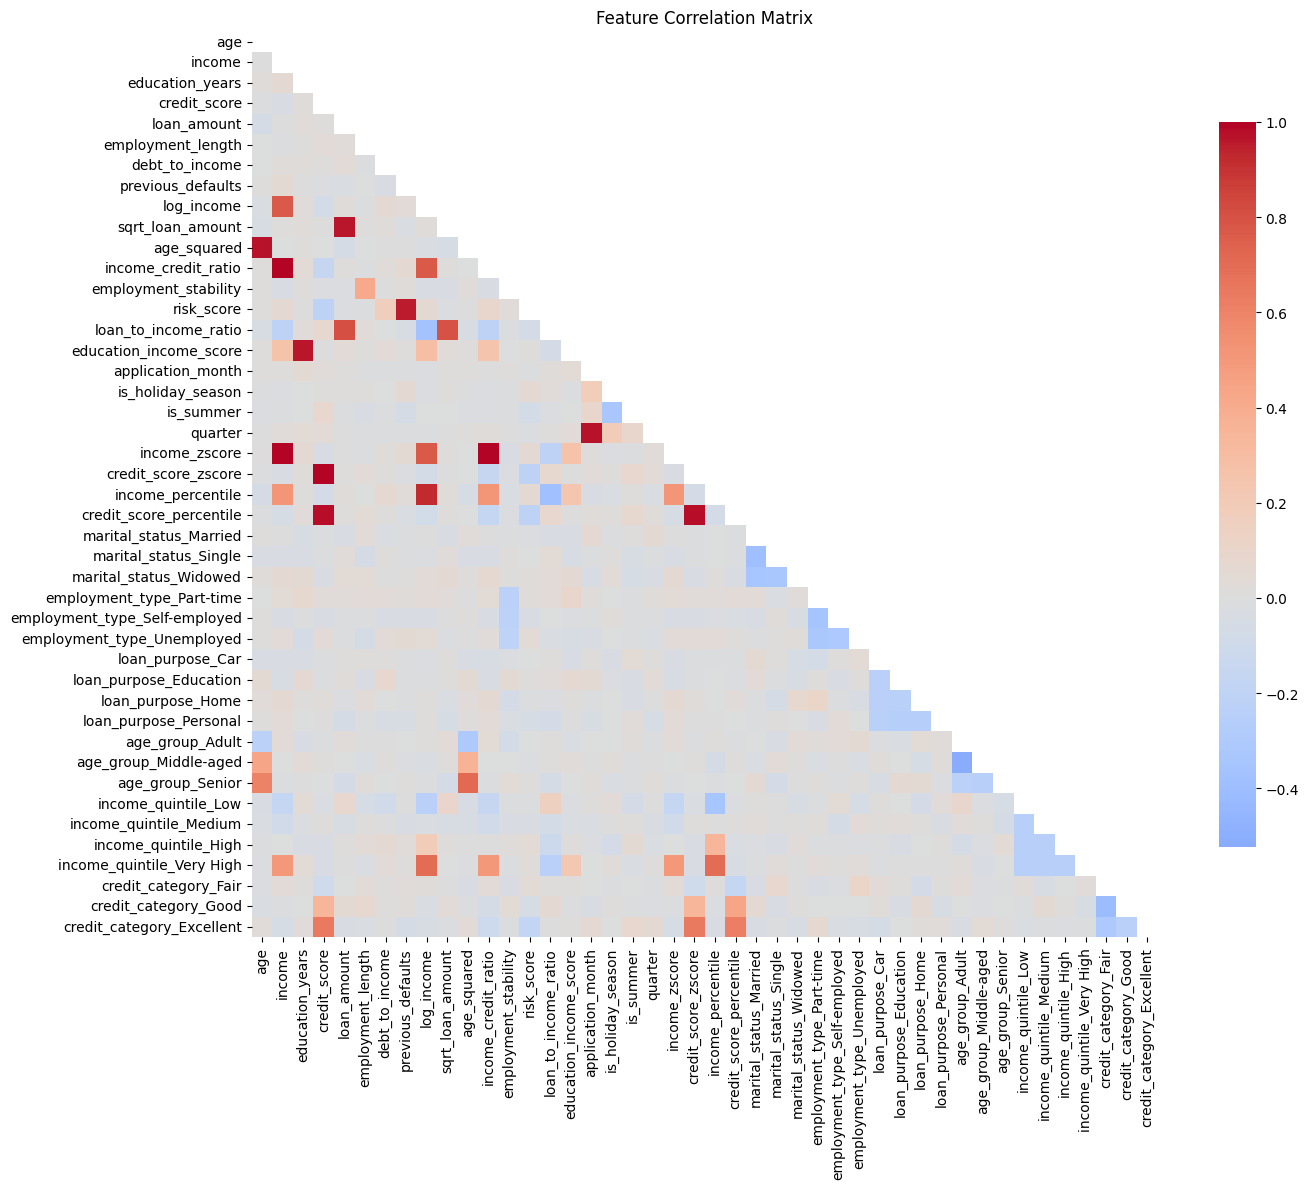

In [19]:
# Calculate correlation matrix
correlation_matrix = X.corr()

# Find highly correlated feature pairs
def find_highly_correlated_features(corr_matrix, threshold=0.8):
    """Find pairs of features with correlation above threshold"""
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_value
                })
    return high_corr_pairs

# Find highly correlated features
high_corr_pairs = find_highly_correlated_features(correlation_matrix, threshold=0.8)
print(f"=== HIGHLY CORRELATED FEATURES (|r| > 0.8) ===")
for pair in high_corr_pairs:
    print(f"{pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


### Method 2: Statistical Feature Selection

Use statistical tests to identify features with significant relationships to the target:


In [20]:
# Statistical feature selection methods
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

# Method 2a: F-test (ANOVA F-statistic)
f_scores, f_pvalues = f_classif(X, y)
f_selector = SelectKBest(score_func=f_classif, k=20)
X_f_selected = f_selector.fit_transform(X, y)

# Get selected feature names
f_selected_features = X.columns[f_selector.get_support()].tolist()
print(f"=== F-TEST FEATURE SELECTION ===")
print(f"Selected {len(f_selected_features)} features using F-test")
print("Top 10 features by F-score:")
f_scores_df = pd.DataFrame({
    'feature': X.columns,
    'f_score': f_scores,
    'p_value': f_pvalues
}).sort_values('f_score', ascending=False)
print(f_scores_df.head(10))

# Method 2b: Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_mi_selected = mi_selector.fit_transform(X, y)

mi_selected_features = X.columns[mi_selector.get_support()].tolist()
print(f"\n=== MUTUAL INFORMATION FEATURE SELECTION ===")
print(f"Selected {len(mi_selected_features)} features using Mutual Information")
print("Top 10 features by MI score:")
mi_scores_df = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)
print(mi_scores_df.head(10))


=== F-TEST FEATURE SELECTION ===
Selected 20 features using F-test
Top 10 features by F-score:
                          feature   f_score   p_value
28  employment_type_Self-employed  5.633227  0.017812
10                    age_squared  4.611826  0.031992
34                age_group_Adult  3.592032  0.058346
0                             age  3.343949  0.067751
14           loan_to_income_ratio  2.531948  0.111879
27      employment_type_Part-time  2.523854  0.112453
32              loan_purpose_Home  2.101192  0.147498
43      credit_category_Excellent  1.895636  0.168876
36               age_group_Senior  1.870397  0.171737
7               previous_defaults  1.639848  0.200644

=== MUTUAL INFORMATION FEATURE SELECTION ===
Selected 20 features using Mutual Information
Top 10 features by MI score:
                       feature  mi_score
26      marital_status_Widowed  0.022596
17           is_holiday_season  0.020333
7            previous_defaults  0.016235
5            employment_le

### Method 3: Model-based Feature Selection

Use machine learning models to identify the most important features:


=== RANDOM FOREST FEATURE IMPORTANCE ===
Top 20 most important features:
                    feature  importance
15   education_income_score    0.055511
13               risk_score    0.054243
6            debt_to_income    0.054181
5         employment_length    0.051756
14     loan_to_income_ratio    0.050710
9          sqrt_loan_amount    0.049833
11      income_credit_ratio    0.045844
4               loan_amount    0.045355
10              age_squared    0.041554
3              credit_score    0.041082
0                       age    0.040646
21      credit_score_zscore    0.040219
1                    income    0.039414
8                log_income    0.038491
20            income_zscore    0.038309
23  credit_score_percentile    0.037778
22        income_percentile    0.037715
2           education_years    0.033424
16        application_month    0.029175
12     employment_stability    0.020053

Selected 22 features using Random Forest importance


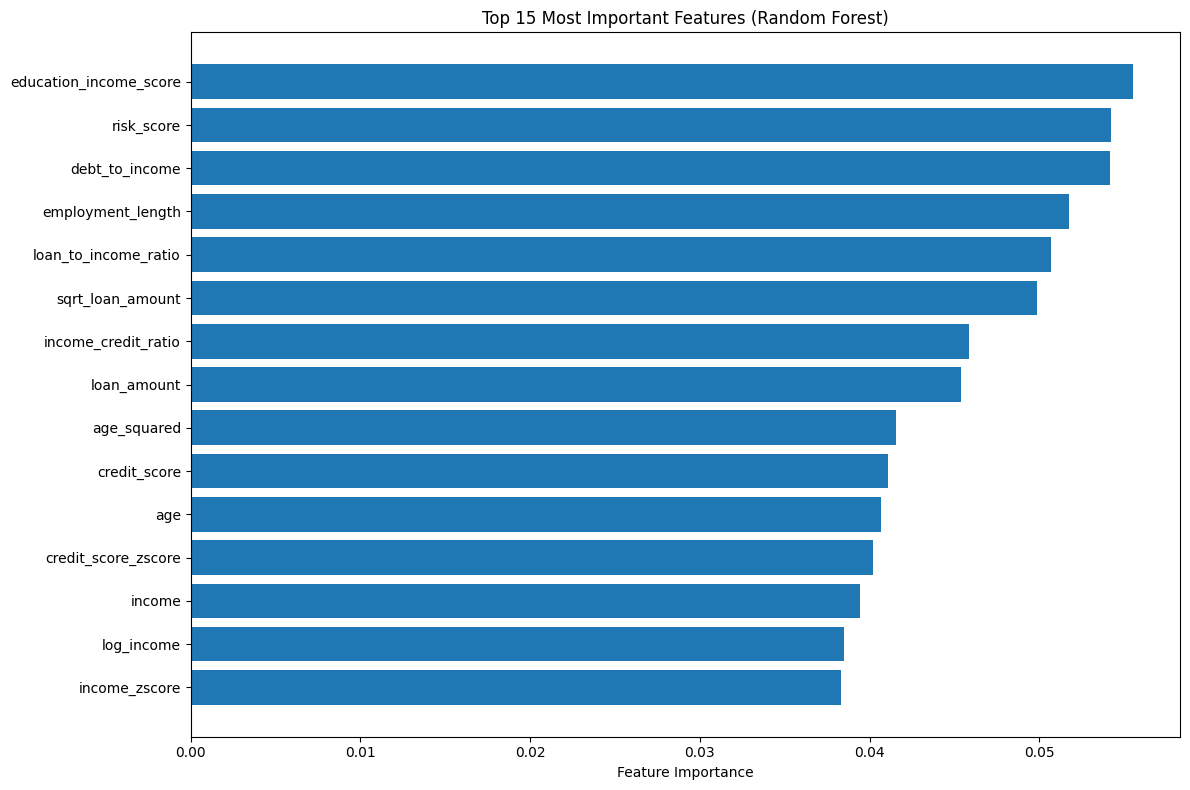

In [21]:
# Model-based feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Train a Random Forest to get feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== RANDOM FOREST FEATURE IMPORTANCE ===")
print("Top 20 most important features:")
print(feature_importance.head(20))

# Select features using Random Forest importance
rf_selector = SelectFromModel(rf_model, threshold='median')
X_rf_selected = rf_selector.fit_transform(X, y)
rf_selected_features = X.columns[rf_selector.get_support()].tolist()

print(f"\nSelected {len(rf_selected_features)} features using Random Forest importance")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Comparing Feature Selection Methods

Let's compare the different feature selection methods and their performance:


=== FEATURE SELECTION COMPARISON ===
                 n_features  cv_mean  cv_std  test_score
All Features           44.0   0.4979  0.0541      0.7264
F-test Selected        20.0   0.5436  0.0412      0.7214
MI Selected            20.0   0.4583  0.0622      0.7264
RF Selected            22.0   0.5058  0.0555      0.7264


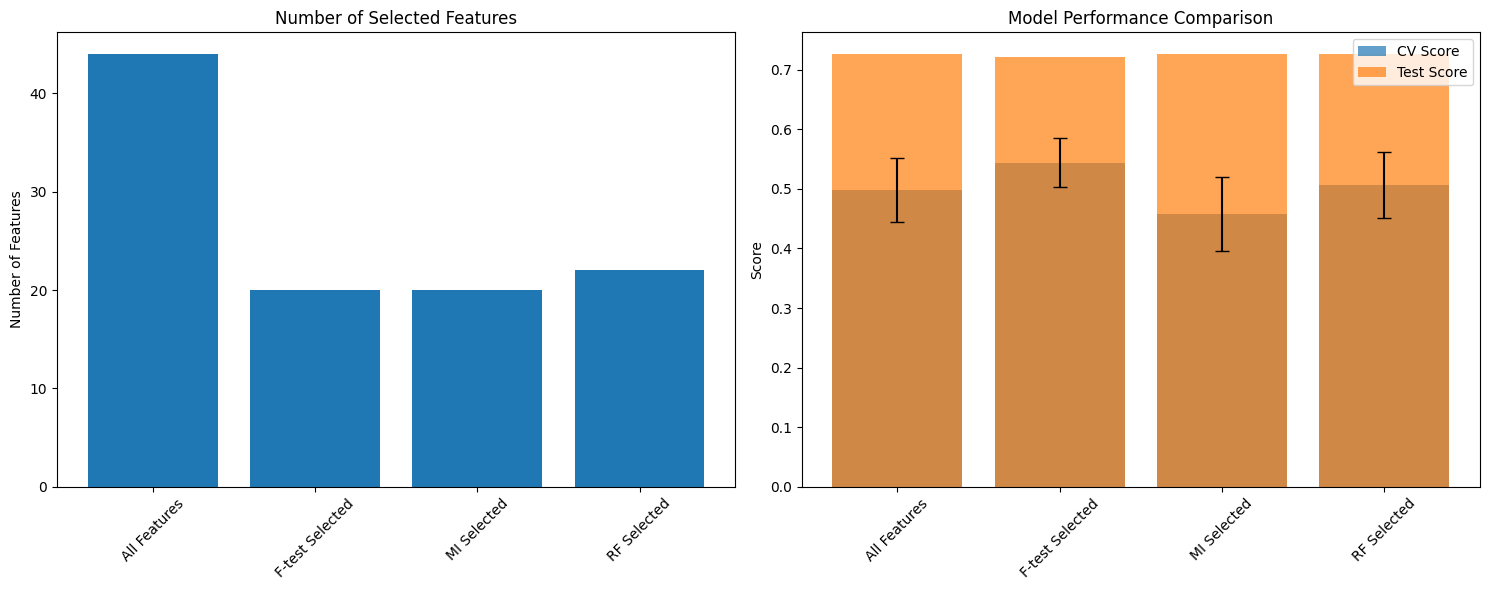

In [22]:
# Compare different feature selection methods
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define different feature sets
feature_sets = {
    'All Features': X.columns.tolist(),
    'F-test Selected': f_selected_features,
    'MI Selected': mi_selected_features,
    'RF Selected': rf_selected_features
}

# Evaluate each feature set
results = {}
for name, features in feature_sets.items():
    # Select features
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]
    
    # Train model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_selected, y_train)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='roc_auc')
    
    # Test score
    test_score = model.score(X_test_selected, y_test)
    
    results[name] = {
        'n_features': len(features),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_score': test_score
    }

# Display results
print("=== FEATURE SELECTION COMPARISON ===")
results_df = pd.DataFrame(results).T
print(results_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Number of features
axes[0].bar(results_df.index, results_df['n_features'])
axes[0].set_title('Number of Selected Features')
axes[0].set_ylabel('Number of Features')
axes[0].tick_params(axis='x', rotation=45)

# Performance comparison
x_pos = range(len(results_df))
axes[1].bar(x_pos, results_df['cv_mean'], yerr=results_df['cv_std'], 
           capsize=5, alpha=0.7, label='CV Score')
axes[1].bar(x_pos, results_df['test_score'], alpha=0.7, label='Test Score')
axes[1].set_title('Model Performance Comparison')
axes[1].set_ylabel('Score')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df.index, rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()


In [23]:
!pip install shap

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.2/559.2 kB 9.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 41.9 MB/s  0:00:00 eta 0:00:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]


## Hands-on Exercise

Now it's your turn! Let's practice what we've learned with a practical exercise.

### Exercise: Build a Complete ETL Pipeline

**Task**: Create a complete ETL pipeline that processes a new dataset with the following requirements:

1. **Extract**: Load data from a CSV file (we'll create one)
2. **Transform**: Clean the data and handle missing values
3. **Load**: Create a final dataset ready for machine learning

Let's start:


In [24]:
# Step 1: Create a new dataset with different characteristics
def create_exercise_dataset(n_samples=500):
    """Create a dataset for the exercise with different data quality issues"""
    np.random.seed(123)
    
    data = {
        'student_id': range(1, n_samples + 1),
        'gpa': np.random.normal(3.2, 0.8, n_samples),
        'sat_score': np.random.normal(1200, 200, n_samples),
        'hours_studied': np.random.exponential(20, n_samples),
        'attendance_rate': np.random.beta(8, 2, n_samples),
        'extracurricular_hours': np.random.poisson(5, n_samples),
        'family_income': np.random.lognormal(10.5, 0.6, n_samples),
        'parent_education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples),
        'study_major': np.random.choice(['Engineering', 'Business', 'Arts', 'Sciences'], n_samples),
        'graduation_probability': np.random.choice([0, 1], n_samples, p=[0.25, 0.75])
    }
    
    df = pd.DataFrame(data)
    
    # Introduce data quality issues
    # Missing values
    missing_indices = np.random.choice(df.index, size=int(0.15 * len(df)), replace=False)
    df.loc[missing_indices, 'gpa'] = np.nan
    
    # Outliers
    outlier_indices = np.random.choice(df.index, size=10, replace=False)
    df.loc[outlier_indices, 'sat_score'] *= 2
    
    # Invalid values
    df.loc[df.sample(5, random_state=123).index, 'gpa'] = -1  # Invalid GPA
    df.loc[df.sample(8, random_state=124).index, 'attendance_rate'] = 1.5  # Invalid attendance
    
    # Inconsistent categorical data
    df.loc[df.sample(15, random_state=125).index, 'parent_education'] = 'high school'  # lowercase
    
    return df

# Create the exercise dataset
exercise_df = create_exercise_dataset(500)
print("=== EXERCISE DATASET CREATED ===")
print(f"Shape: {exercise_df.shape}")
print(f"Missing values: {exercise_df.isnull().sum().sum()}")
print("\nFirst few rows:")
exercise_df.head()


=== EXERCISE DATASET CREATED ===
Shape: (500, 10)
Missing values: 74

First few rows:


,student_id,gpa,sat_score,hours_studied,attendance_rate,extracurricular_hours,family_income,parent_education,study_major,graduation_probability
0,1,2.331496,1350.406734,27.112140,0.911512,3,37683.868411,High School,Sciences,1
1,2,NaN,1213.928150,3.980082,0.784096,4,20354.526595,Bachelor,Engineering,1
2,3,3.426383,1146.910875,5.019155,0.823647,5,55627.485918,PhD,Business,1
3,4,NaN,1385.916894,24.066743,0.965914,5,18084.412269,PhD,Business,1
4,5,2.737120,1452.164254,31.646605,0.652629,10,57177.520437,PhD,Arts,1


### Your Turn! Complete the ETL Pipeline

**Instructions**: Complete the following tasks step by step. Try to solve each step before looking at the solution.

#### Task 1: Data Exploration
First, explore the dataset and identify all data quality issues:


In [25]:
# TODO: Complete this section
# 1. Check basic dataset information (shape, dtypes, memory usage)
# 2. Identify missing values
# 3. Check for duplicates
# 4. Identify outliers and invalid values
# 5. Check categorical data consistency

# Your code here:
print("=== YOUR TASK: EXPLORE THE DATASET ===")
print("Complete the data exploration above...")

# Hint: Use similar code to what we used earlier in the notebook
# Check shape, missing values, duplicates, etc.


=== YOUR TASK: EXPLORE THE DATASET ===
Complete the data exploration above...


#### Task 2: Data Cleaning
Clean the dataset by handling all identified issues:


In [26]:
# TODO: Complete this section
# 1. Remove duplicates
# 2. Fix invalid values (negative GPA, attendance > 1)
# 3. Standardize categorical data
# 4. Handle outliers appropriately

# Your code here:
print("=== YOUR TASK: CLEAN THE DATASET ===")
print("Complete the data cleaning above...")

# Hint: 
# - Use drop_duplicates() for duplicates
# - Replace invalid values with appropriate statistics
# - Use str.title() or str.capitalize() for categorical standardization
# - Consider using IQR method for outlier detection


=== YOUR TASK: CLEAN THE DATASET ===
Complete the data cleaning above...


#### Task 3: Missing Value Imputation
Choose appropriate imputation methods for different variables:


In [27]:
# TODO: Complete this section
# 1. Analyze the pattern of missing data
# 2. Choose appropriate imputation methods for each variable
# 3. Implement the imputation
# 4. Validate the results

# Your code here:
print("=== YOUR TASK: IMPUTE MISSING VALUES ===")
print("Complete the missing value imputation above...")

# Hint:
# - For GPA: consider using median or group-based imputation
# - Analyze if missing data is random or systematic
# - Use different methods and compare results
# - Consider using KNN or other advanced methods


=== YOUR TASK: IMPUTE MISSING VALUES ===
Complete the missing value imputation above...


#### Task 4: Feature Engineering
Create new meaningful features from the existing data:


In [28]:
# TODO: Complete this section
# 1. Create mathematical transformations (log, sqrt, etc.)
# 2. Create interaction features
# 3. Create binned/categorical features
# 4. Create domain-specific features

# Your code here:
print("=== YOUR TASK: ENGINEER NEW FEATURES ===")
print("Complete the feature engineering above...")

# Hint: Consider creating features like:
# - Academic performance score (GPA * attendance)
# - Study efficiency (GPA / hours_studied)
# - Family education level (encode parent_education numerically)
# - Income categories
# - Study load (hours_studied + extracurricular_hours)
# - Academic potential (SAT score / family_income)


=== YOUR TASK: ENGINEER NEW FEATURES ===
Complete the feature engineering above...


#### Task 5: Feature Selection
Select the most relevant features for your model:


In [29]:
# TODO: Complete this section
# 1. Calculate correlation matrix
# 2. Remove highly correlated features
# 3. Use statistical tests for feature selection
# 4. Use model-based feature selection
# 5. Compare different feature sets

# Your code here:
print("=== YOUR TASK: SELECT BEST FEATURES ===")
print("Complete the feature selection above...")

# Hint:
# - Use correlation analysis to remove redundant features
# - Apply F-test or mutual information for statistical selection
# - Use Random Forest feature importance
# - Compare model performance with different feature sets
# - Aim for 10-15 most important features


=== YOUR TASK: SELECT BEST FEATURES ===
Complete the feature selection above...


### Solution: Complete ETL Pipeline

Here's a complete solution for the exercise. Try to implement it yourself first!


In [30]:
# SOLUTION: Complete ETL Pipeline

# Step 1: Data Exploration
print("=== STEP 1: DATA EXPLORATION ===")
print(f"Dataset shape: {exercise_df.shape}")
print(f"Memory usage: {exercise_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nMissing values:")
missing_data = exercise_df.isnull().sum()
print(missing_data[missing_data > 0])

print(f"\nDuplicates: {exercise_df.duplicated().sum()}")

# Check for invalid values
print(f"\nInvalid GPAs (< 0): {(exercise_df['gpa'] < 0).sum()}")
print(f"Invalid attendance (> 1): {(exercise_df['attendance_rate'] > 1).sum()}")

# Check categorical consistency
print(f"\nParent education unique values:")
print(exercise_df['parent_education'].value_counts())

# Step 2: Data Cleaning
print("\n=== STEP 2: DATA CLEANING ===")

# Remove duplicates
df_clean = exercise_df.drop_duplicates()
print(f"Removed {len(exercise_df) - len(df_clean)} duplicates")

# Fix invalid values
df_clean.loc[df_clean['gpa'] < 0, 'gpa'] = df_clean[df_clean['gpa'] >= 0]['gpa'].median()
df_clean.loc[df_clean['attendance_rate'] > 1, 'attendance_rate'] = 1.0

# Standardize categorical data
df_clean['parent_education'] = df_clean['parent_education'].str.title()

print("✓ Data cleaning completed")

# Step 3: Missing Value Imputation
print("\n=== STEP 3: MISSING VALUE IMPUTATION ===")

# Use median imputation for GPA
df_clean['gpa'].fillna(df_clean['gpa'].median(), inplace=True)
print(f"Imputed {missing_data['gpa']} missing GPA values with median")

# Step 4: Feature Engineering
print("\n=== STEP 4: FEATURE ENGINEERING ===")

# Create new features
df_clean['academic_performance'] = df_clean['gpa'] * df_clean['attendance_rate']
df_clean['study_efficiency'] = df_clean['gpa'] / (df_clean['hours_studied'] + 1)
df_clean['total_engagement'] = df_clean['hours_studied'] + df_clean['extracurricular_hours']
df_clean['income_category'] = pd.cut(df_clean['family_income'], 
                                    bins=3, labels=['Low', 'Medium', 'High'])

# Encode parent education numerically
education_mapping = {'High School': 1, 'Bachelor': 2, 'Master': 3, 'Phd': 4}
df_clean['parent_education_numeric'] = df_clean['parent_education'].map(education_mapping)

print("✓ Feature engineering completed")
print(f"New dataset shape: {df_clean.shape}")

# Step 5: Feature Selection
print("\n=== STEP 5: FEATURE SELECTION ===")

# Prepare data for feature selection
X = df_clean.drop(['student_id', 'graduation_probability'], axis=1)
y = df_clean['graduation_probability']

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Use Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_encoded, y)

# Get top 10 most important features
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(10)['feature'].tolist()
print(f"Top 10 most important features:")
print(top_features)

# Create final dataset
final_features = X_encoded[top_features]
final_dataset = pd.concat([final_features, y], axis=1)

print(f"\n=== FINAL DATASET ===")
print(f"Shape: {final_dataset.shape}")
print(f"Features: {list(final_features.columns)}")
print(f"Target distribution: {y.value_counts().to_dict()}")

print("\n✅ ETL Pipeline completed successfully!")


=== STEP 1: DATA EXPLORATION ===
Dataset shape: (500, 10)
Memory usage: 0.09 MB

Missing values:
gpa    74
dtype: int64

Duplicates: 0

Invalid GPAs (< 0): 5
Invalid attendance (> 1): 8

Parent education unique values:
parent_education
High School    135
Bachelor       132
PhD            111
Master         107
high school     15
Name: count, dtype: int64

=== STEP 2: DATA CLEANING ===
Removed 0 duplicates
✓ Data cleaning completed

=== STEP 3: MISSING VALUE IMPUTATION ===
Imputed 74 missing GPA values with median

=== STEP 4: FEATURE ENGINEERING ===
✓ Feature engineering completed
New dataset shape: (500, 15)

=== STEP 5: FEATURE SELECTION ===
Top 10 most important features:
['hours_studied', 'study_efficiency', 'family_income', 'academic_performance', 'attendance_rate', 'total_engagement', 'sat_score', 'gpa', 'extracurricular_hours', 'parent_education_numeric']

=== FINAL DATASET ===
Shape: (500, 11)
Features: ['hours_studied', 'study_efficiency', 'family_income', 'academic_performanc

## Summary and Best Practices

Congratulations! You've learned the fundamentals of data preprocessing, ETL, and feature engineering. Let's summarize the key takeaways and best practices:


### Key Takeaways

1. **ETL Process is Critical**: The quality of your data preprocessing directly impacts model performance
2. **Missing Data Strategy**: Choose imputation methods based on data mechanism (MCAR, MAR, MNAR)
3. **Feature Engineering**: Domain knowledge is crucial for creating meaningful features
4. **Feature Selection**: Balance between model performance and interpretability
5. **Validation**: Always validate your preprocessing steps with domain experts

### Best Practices for Data Preprocessing


#### 1. Data Quality Assessment
- **Always start with data exploration**: Understand your data before cleaning
- **Document data quality issues**: Keep track of what you find and how you fix it
- **Validate with domain experts**: Ensure your assumptions are correct

#### 2. Missing Data Handling
- **Understand the mechanism**: MCAR, MAR, or MNAR
- **Choose appropriate methods**: Simple statistics vs. advanced ML methods
- **Validate imputation**: Check if imputed values make sense
- **Consider multiple imputation**: For critical analyses

#### 3. Feature Engineering
- **Domain knowledge first**: Understand the business context
- **Start simple**: Basic transformations before complex interactions
- **Validate new features**: Ensure they add value to the model
- **Avoid data leakage**: Don't use future information

#### 4. Feature Selection
- **Remove redundant features**: High correlation often indicates redundancy
- **Use multiple methods**: Combine statistical and model-based approaches
- **Cross-validate**: Ensure selected features generalize well
- **Document decisions**: Keep track of why features were selected/dropped


### Common Pitfalls to Avoid

1. **Over-engineering features**: Too many features can lead to overfitting
2. **Ignoring data leakage**: Using future information to predict past events
3. **Inappropriate imputation**: Using mean for skewed distributions
4. **Not validating assumptions**: Always check if your preprocessing makes sense
5. **Ignoring business context**: Technical solutions that don't align with business needs

### Next Steps

1. **Practice with real datasets**: Apply these techniques to actual projects
2. **Learn advanced techniques**: Explore more sophisticated imputation methods
3. **Study domain-specific preprocessing**: Different industries have different requirements
4. **Automate your pipelines**: Create reusable preprocessing workflows
5. **Stay updated**: Data preprocessing techniques evolve constantly

### Additional Resources

- **Scikit-learn documentation**: Comprehensive guide to preprocessing techniques
- **Pandas documentation**: Essential for data manipulation
- **Domain-specific guides**: Learn preprocessing techniques for your industry
- **Online courses**: Advanced data preprocessing and feature engineering
- **Research papers**: Stay updated with latest techniques

---

## Conclusion

Data preprocessing is the foundation of successful machine learning projects. The techniques you've learned today will serve you well in any data science role. Remember: **"The best model is only as good as the data it's trained on."**

**Key Skills Developed:**
- ✅ ETL process design and implementation
- ✅ Missing data analysis and imputation
- ✅ Feature engineering and selection
- ✅ Data quality assessment and cleaning
- ✅ Practical problem-solving with real datasets

**Happy Data Preprocessing! 🚀**
